# Pokemon - Base Stats and Types
**Description:** Is there a correlation between a Pokemon's primary type and its highest stat? 

**Goal:** To find a relationship between a Pokemon's main type and their highest base stats to gain insight into the minds of Pokemon designers.

<img src="https://github.com/Mushtatoes/proj/blob/master/pikachu.png?raw=true" width="300"/>


---



**Example:** Rock pokemon might generally have defense as their highest stat.
Maybe Psychic pokemon might have generally high special attack. 
Are there any outlier pokemon that may be a bit different from others of the same type?




In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re

## 1. Obtaining Data


>- No mega-evolutions, alternate forms, etc.
- Pulling from PokeAPI
- Manually parse and add data into Dataframe without using read_json
- At time of writing, there are currently 807 unique Pokemon in the API (Up to Gen 7)




In [0]:
pokemon_json = requests.get('https://pokeapi.co/api/v2/pokemon?&limit=5000').json()
# print(pokemon_json)

#### 1a. Filter out non-standard Pokemon by id:
>- Create a list of urls that can be used to pull data on each Pokemon.
- PokeAPI uses id <= 10000 to identify standard Pokemon and their traits.
- Use regular expressions to isolate the id from the url and compare.

In [0]:
name_url_raw = pokemon_json['results']

# Filter out non-standard Pokemon using regex on url:
def pokemon_filter(pokemon_object):
  pokemon_search = re.search('^https://pokeapi\.co/api/v2/pokemon/(\d+)/$', pokemon_object['url'])
  if not pokemon_search:
    return False
  return int(pokemon_search.group(1)) <= 10000

name_url = list(filter(pokemon_filter, name_url_raw))

pokemon_urls = [x['url'] for x in name_url]


#### 1b. Map the required data:
>- Each Pokemon's base stats can only be found on their own page, which means a request for each Pokemon.
- Storing into a flat file or SQL table would be preferable if the data is  required for reuse in the future.

In [0]:
# Return each pokemon's name, type1, and base stats:
def pokemon_map(url):
  pokemon = requests.get(url).json()
  data = {'name': pokemon['name']
          ,'type1': ''.join([t['type']['name'] for t in pokemon['types'] if t['slot'] == 1])
          ,'stats': {s['stat']['name']: s['base_stat']for s in pokemon['stats']}}
  return data
  
pokemon_data = list(map(pokemon_map, pokemon_urls))

# print(pokemon_data)

#### 1c. Push the data into a pandas DataFrame:
> - Names and types can be extracted into separate lists.
- Each pokemon has 6 base stats:
  - hp
  - attack
  - special-attack
  - defense
  - special-defense
  - speed
- These will have to each be placed into separate lists to push into the DataFrame.

In [5]:
# Format data into dictionaries for DataFrame:
# {Header: [data]}

def pivot_data(category, subcategory = None):
  if not subcategory:
    return [pokemon[category] for pokemon in pokemon_data]
  else:
    return [pokemon[category][subcategory] for pokemon in pokemon_data]

pokemon_name = pivot_data('name')
pokemon_type1 = pivot_data('type1')
pokemon_spd = pivot_data('stats', 'speed')
pokemon_spdef = pivot_data('stats', 'special-defense')
pokemon_spatk = pivot_data('stats', 'special-attack')
pokemon_def = pivot_data('stats', 'defense')
pokemon_atk = pivot_data('stats', 'attack')
pokemon_hp = pivot_data('stats', 'hp')

pokemon_df = pd.DataFrame({'Name': pokemon_name
                           ,'Type1': pokemon_type1
                           ,'SPD': pokemon_spd
                           ,'SPDEF': pokemon_spdef
                           ,'SPATK': pokemon_spatk
                           ,'DEF': pokemon_def
                           ,'ATK': pokemon_atk
                           ,'HP': pokemon_hp})

# Display top rows from DataFrame for preview:

pokemon_df.head()

,Name,Type1,SPD,SPDEF,SPATK,DEF,ATK,HP
0,bulbasaur,grass,45,65,65,49,49,45
1,ivysaur,grass,60,80,80,63,62,60
2,venusaur,grass,80,100,100,83,82,80
3,charmander,fire,65,50,60,43,52,39
4,charmeleon,fire,80,65,80,58,64,58


## 2. Calculations and Visuals



#### 2a. Calculate weighted stats:
> - Create binary versions of stat columns (max = 1, not max = 0)
- Sum highest base stats across each Pokemon and divide by the count of highest stats.
- E.g. Bulbasaur has equal highest SPDEF and SPATK: count 0.5 SPDEF AND 0.5 ATK.


In [6]:
# List of the stats to to focus DataFrame row operations on stats:
stat_list = ['SPD','SPDEF','SPATK','DEF','ATK','HP']
bin_stat_list = ['bin_spd', 'bin_spdef', 'bin_spatk', 'bin_def', 'bin_atk', 'bin_hp']

pokemon_count = pokemon_df.Name.count()

# Assign binary logic to highest base stats for each Pokemon:
def hi_stat_bin(row, stat):
  return int(stat.iloc[row] == pokemon_df[stat_list].iloc[row].max())

pokemon_df['bin_spd'] = [hi_stat_bin(x, pokemon_df.SPD) for x in range(pokemon_count)]
pokemon_df['bin_spdef'] = [hi_stat_bin(x, pokemon_df.SPDEF) for x in range(pokemon_count)]
pokemon_df['bin_spatk'] = [hi_stat_bin(x, pokemon_df.SPATK) for x in range(pokemon_count)]
pokemon_df['bin_def'] = [hi_stat_bin(x, pokemon_df.DEF) for x in range(pokemon_count)]
pokemon_df['bin_atk'] = [hi_stat_bin(x, pokemon_df.ATK) for x in range(pokemon_count)]
pokemon_df['bin_hp'] = [hi_stat_bin(x, pokemon_df.HP) for x in range(pokemon_count)]

# Sum binary logic columns to see how many highest equal max stats each Pokemon has:
pokemon_df['hi_val'] = [sum(pokemon_df[bin_stat_list].iloc[x]) for x in range(pokemon_count)]

# Divide each column by number of highest equal max stats to weigh sum of each Pokemon stats to 1:
pokemon_df['wSPD'] = round(pokemon_df['bin_spd']/pokemon_df['hi_val'],2)
pokemon_df['wSPDEF'] = round(pokemon_df['bin_spdef']/pokemon_df['hi_val'],2)
pokemon_df['wSPATK'] = round(pokemon_df['bin_spatk']/pokemon_df['hi_val'],2)
pokemon_df['wDEF'] = round(pokemon_df['bin_def']/pokemon_df['hi_val'],2)
pokemon_df['wATK'] = round(pokemon_df['bin_atk']/pokemon_df['hi_val'],2)
pokemon_df['wHP'] = round(pokemon_df['bin_hp']/pokemon_df['hi_val'],2)

pokemon_df.head()


,Name,Type1,SPD,SPDEF,SPATK,DEF,ATK,HP,bin_spd,bin_spdef,bin_spatk,bin_def,bin_atk,bin_hp,hi_val,wSPD,wSPDEF,wSPATK,wDEF,wATK,wHP
0,bulbasaur,grass,45,65,65,49,49,45,0,1,1,0,0,0,2,0.0,0.5,0.5,0.0,0.0,0.0
1,ivysaur,grass,60,80,80,63,62,60,0,1,1,0,0,0,2,0.0,0.5,0.5,0.0,0.0,0.0
2,venusaur,grass,80,100,100,83,82,80,0,1,1,0,0,0,2,0.0,0.5,0.5,0.0,0.0,0.0
3,charmander,fire,65,50,60,43,52,39,1,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0
4,charmeleon,fire,80,65,80,58,64,58,1,0,1,0,0,0,2,0.5,0.0,0.5,0.0,0.0,0.0


#### 2b. Aggregate data:
>- Use group by function to sum data by type, using only required columns for plotting.
- Reset index so the Type1 column can be indexed from the new DataFrame.


In [7]:
type1_stat_df = pokemon_df[['Type1','wSPD','wSPDEF','wSPATK','wDEF','wATK','wHP']].groupby('Type1').sum().reset_index()

type1_stat_df

,Type1,wSPD,wSPDEF,wSPATK,wDEF,wATK,wHP
0,bug,15.00,7.00,8.50,21.50,18.00,2.00
1,dark,5.00,1.50,6.50,2.00,12.00,2.00
2,dragon,0.00,5.00,3.00,5.00,14.00,0.00
3,electric,21.00,0.00,12.00,0.00,7.00,0.00
4,fairy,0.00,7.50,2.00,2.50,2.50,3.50
5,fighting,3.67,2.17,1.17,0.17,18.67,3.17
6,fire,16.00,2.00,21.00,3.00,9.50,1.50
7,flying,2.00,0.00,1.00,0.00,0.00,0.00
8,ghost,0.66,3.66,6.66,8.00,5.00,3.00
9,grass,13.34,9.67,15.84,12.17,17.84,9.17


#### 2c. Plot data:
>- Use bar charts to give a better visual display of differences in values.
- Subplots can be used to create a bar graph for each type in the new aggregated DataFrame.
- Give graphs for each type the same tick size.


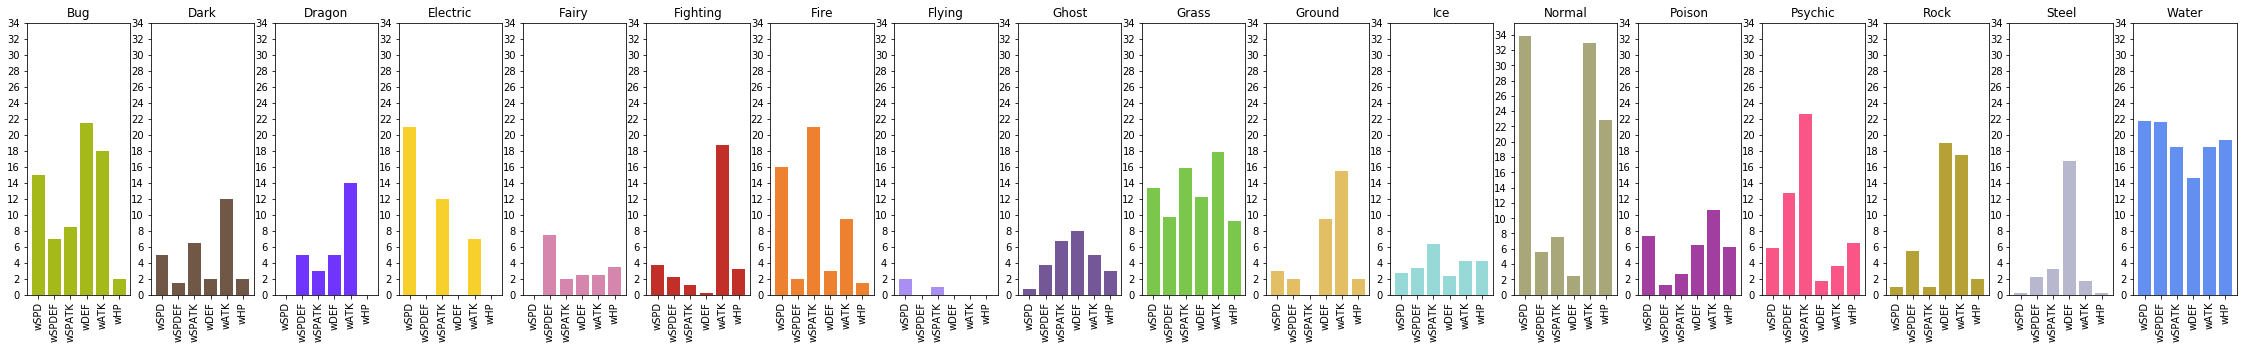

In [8]:
# Saving all types and all stats to increase readability:
types = type1_stat_df.Type1
stats = type1_stat_df.columns[1:]

# HTML colors for each type:
type_colors = {'bug': '#A6B91A', 'dark': '#705746', 'dragon': '#6F35FC', 'electric': '#F7D02C', 'fairy': '#D685AD', 'fighting': '#C22E28'
, 'fire': '#EE8130', 'flying': '#A98FF3', 'ghost': '#735797', 'grass': '#7AC74C', 'ground': '#E2BF65', 'ice': '#96D9D6'
, 'normal': '#A8A77A', 'poison': '#A33EA1', 'psychic': '#F95587', 'rock': '#B6A136', 'steel': '#B7B7CE', 'water': '#6390F0'}

# Saving the xticks and yticks locations:
x = range(len(stats))
y = range(0, round(max(list(type1_stat_df[['wSPD','wSPDEF','wSPATK','wDEF','wATK','wHP']].max(axis = 1))))+ 2, 2)

# Create function to pull type subplots based on parameters:
ntypes = {t : i for i, t in enumerate(types)}

def format_fig(pokemon_types):
  n = len(pokemon_types)
  fig, ax = plt.subplots(1, n, figsize = (n * 2.2, 5))
  type_to_index = [ntypes[type1] for type1 in pokemon_types]
  if n == 1: # One subplot cannot be index with ax[0]:
    t = ntypes[''.join(pokemon_types)]
    ax.bar(x, type1_stat_df.iloc[t][1:], color = list(type_colors.values())[t])
    ax.set_xticks(x)
    ax.set_xticklabels(stats, rotation = 90)
    ax.set_yticks(y)
    ax.set_title(types[t].capitalize())
  else:
    for i, t in enumerate(type_to_index):
      ax[i].bar(x, type1_stat_df.iloc[t][1:], color = list(type_colors.values())[t])
      ax[i].set_xticks(x)
      ax[i].set_xticklabels(stats, rotation = 90)
      ax[i].set_yticks(y)
      ax[i].set_title(types[t].capitalize())
  plt.show()

format_fig(types)

## 3. Analysis and Conclusion


#### Things to keep in mind:
>- These are weighted counts of each Pokemon's highest base stat. It is possible for many Pokemon to have their second highest base stat right under their highest; but since binary logic was used to make the calculations simpler, the second highest base stat is ignored.
- Secondary types are not included: these are assumptions made only on the Pokemon's primary type and their base stats.

#### 3a. Single stat count is the clear highest:

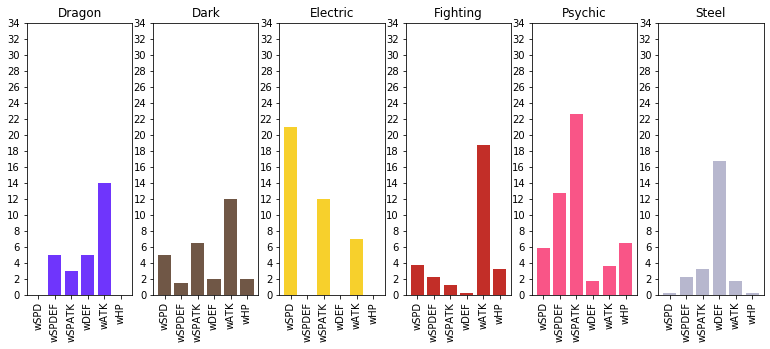

In [9]:
format_fig(['dragon', 'dark', 'electric', 'fighting', 'psychic', 'steel'])

**Dragon**
> Attack is the clear highest here, but maybe not because dragons are always known in fantasies for being hostile in nature towards medieval knights. It is more likely for gameplay purposes. There are almost no special-attack dragon moves. The only ones available to most dragons are Draco Meteor and Dragon Pulse, while physical attack dragons have a wide variety of options; including Dragon Dance to buff attack as icing on the cake.

**Dark**
> This is similar to Dragon type, the high attack count is likely due to gameplay purposes. Dark types were originally created to trump Psychic types (psychic type moves do not affect Dark types), which are Pokemon with a generally low physical defense stat.

**Electric**
> As many would think, many electric Pokemon have speed as their highest stat. Thunder/Electricity is naturally extremely fast in the real world and this property is reflected in Pokemon. An interesting thing to note is that attack and special-attack are the only other highest base stats. This is likely to utilize electric pokemon's high speed for offensive gameplay.

**Fighting**
> As hypothesized, Pokemon whose primary type is fighting generally have attack as their highest base stat. They are consistent with a meaning that "fighting" implies: being hard-hitters and having powerful physical damage.

**Psychic**
> Psychic types are the mages, or magic users of the Pokemon universe. Therefore, it makes sense that their special attack is high. Special attacks consist of damage that's generally done supernaturally or elementally; basically not kicking, punching, or throwing things.

**Steel**
> Similar to electric types, this is likely inspired from the real world. Steel is generally regarded to as a hard, strong element that makes up much of our industrial world.

In [0]:
pokemon_df[(pokemon_df['Type1'] == 'dark') & (pokemon_df['bin_atk'] != 0)]